In [1]:
import ChiantiPy
import ChiantiPy.core as ch
import ChiantiPy.tools.filters as chfilters
import ChiantiPy.tools.io as chio
import numpy as np
import atomic_species as at
import scipy.integrate as sp_int
import scipy.interpolate as sp_intpl
import matplotlib.pyplot as plt
import pandas as pd
import constants as const
import scipy.special as sp_special
import scipy.io as sp_io
import star_grid_new as sg
from copy import deepcopy
import functools as ft
from astropy.io import fits
import h5py
from flatstar import draw, utils

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
#constants 

c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [3]:
##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

norm_ss = normalize_spectrum(ss, 10**3)

In [4]:
#get star spectra from fits 

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}

K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')

norm_F4 = normalize_spectrum(F4, 10**3)

## Photoionization Equilibrium Solver

In [5]:
Zelem_lc = {'h':1, 'he':2, 'li':3, 'be':4, 'b':5, 'c':6, 'n':7,
              'o':8, 'f':9,'ne':10, 'na':11, 'mg':12, 'al':13,
              'si':14, 's':16, 'ar':18, 'ca':20, 'fe':26}

Aelem_lc = {'h':1,'he': 4,'li': 6,'be': 8,'b': 10,'c': 12,'n': 14,
              'o': 16,'f': 18,'ne': 20,'na': 22,'mg': 24,'al': 26,
              'si': 28,'s': 32,'ar': 36,'ca': 40,'fe': 52}


#get photoionization rates for atoms froms Verner.csv
def get_phion_rates(species, stellar_spectrum):
    #species in chianti format (need to change to McAstro format)
    Z = Zelem_lc[species]
    phion_rates = np.zeros(Z, 'float64')

    F_nu, nu = stellar_spectrum['F_nu'], stellar_spectrum['nu']

    for i in range(Z):
        ion = at.atomic_species(species.capitalize() + ' ' + at.arabic_to_roman(i+1))
        phion_rate = np.abs(sp_int.trapezoid(F_nu * ion.cross_section(nu * const.h * const.erg) / (const.h * nu), nu))
        phion_rates[i] = phion_rate

    return phion_rates

#get helium triplet state photoionization rate
#ionization data from Norcross (1971)
def get_triplet_rate(stellar_spectrum):
    
    F_nu, nu = stellar_spectrum['F_nu'][::-1], stellar_spectrum['nu'][::-1]
    xs_He3_data = pd.read_csv('HeMetastableData.csv', skiprows = 1)
    w = c / (data['wvl'].values * 1e-8)
    F_w = np.interp(w, nu, F_nu)
    He3_phion_rate = sp_int.simpson(F_w * data['sigma'].values * 8.067e-18 / (const.h * w), x = w)
    
    return He3_phion_rate
    

#get recombination rate from chianti
def get_rr_rates(species, T):

    #get atomic Z of species
    Z = Zelem_lc[species]
    rr_rates = np.zeros(Z, 'float64')

    #loop through chianti to get recombination rates
    for i in range(Z):
        ion = ch.ion(f'{species}_{i + 2}', temperature = T, setup=0)
        ion.recombRate()
        rr_rates[i] = ion.RecombRate['rate'][0]

    return rr_rates

In [6]:
def Arrhenius(A, B, C, T):
    return A * T**B * np.exp(-C / T)

In [56]:
#photoionization solver hydrogen
def flux_averaged_xs(species, stellar_spectrum):

    Z = Zelem_lc[species]
    flux_averaged_xs = np.zeros(Z, 'float64')

    wvl_mask = (stellar_spectrum['wl'] < 9.12e-6) & (stellar_spectrum['wl'] > 1e-6) #only include hydrogen ionizing rad
    
    F_nu, nu = stellar_spectrum['F_nu'][wvl_mask], stellar_spectrum['nu'][wvl_mask]

    for i in range(Z):
        ion = at.atomic_species(species.capitalize() + ' ' + at.arabic_to_roman(i+1))
        xs = np.abs(sp_int.trapezoid(F_nu * ion.cross_section(nu * const.h * const.erg), x = nu) /
                sp_int.trapezoid(F_nu, x = nu))
    
        flux_averaged_xs[i] = xs
    
    return xs

def cum_phot_rate(species, stellar_spectrum):

    Z = Zelem_lc[species]

    wvl_mask = stellar_spectrum['wl'] < 9.12e-6
    
    F_nu, nu, wl = stellar_spectrum['F_nu'][wvl_mask][::-1], stellar_spectrum['nu'][wvl_mask][::-1], stellar_spectrum['wl'][wvl_mask][::-1]

    cumgamma = np.zeros((Z, len(nu)), 'float64')

    for i in range(Z):
        ion = at.atomic_species(species.capitalize() + ' ' + at.arabic_to_roman(i+1))
        gamma = np.abs(sp_int.cumulative_trapezoid(F_nu * ion.cross_section(nu * const.h * const.erg) / (const.h * nu), x = nu, initial=0)) 
    
        cumgamma[i, :] = gamma
    
    return gamma, wl, nu

    
    

def get_nHI(nH, gamma, rr):
    nHI = nH * (1 + (gamma - np.sqrt(gamma**2 + 4 * rr * nH * gamma)) / (2 * rr * nH))
    return nHI

def get_ne(nH, gamma, rr):
    return nH - get_nHI(nH, gamma, rr)

def get_tau_phot(nH, gamma, rr, D, stellar_spectrum):
    xs = flux_averaged_xs('h', stellar_spectrum)
    return nHI(nH, gamma, rr) * xs * D

def get_nH(tau, gamma, rr, D, stellar_spectrum):
    xs = flux_averaged_xs('h', stellar_spectrum)
    return tau / (D * xs_phot) + np.sqrt((tau * gamma) / (rr * D * xs_phot))


class HPhESolver:
    #class to calculate number hydrogen and protons
    def __init__(self, stellar_spectrum, nH):
        self.stellar_spectrum = stellar_spectrum
        self.nH = nH

    def calculate_abundances(self, T):
        phi_rate = get_phion_rates('h', self.stellar_spectrum)[0]
        rr_rate = get_rr_rates('h', T)[0]
        nHI = get_nHI(self.nH, phi_rate, rr_rate)
        nHII = get_ne(self.nH, phi_rate, rr_rate)
        return np.array([nHI, nHII]) / self.nH

#for all other elements, we assume that the electron number density is dominated by hydrogen ionization, so we assume all electrons from hydrogen 


In [29]:
flux_averaged_xs('h', norm_ss)

9.26163e-19

In [57]:
gamma, wl, nu = cum_phot_rate('h', norm_ss)

Text(0, 0.5, 'cumulative photoionization rate')

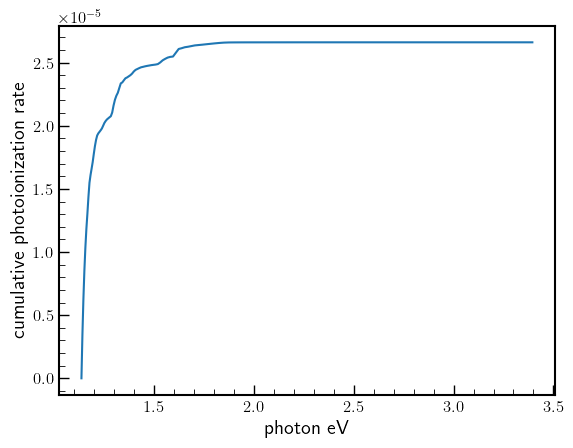

In [68]:
plt.plot(np.log10(nu*const.h*const.erg), gamma)
plt.xlabel('photon eV')
plt.ylabel('cumulative photoionization rate')

In [14]:
at.atomic_species('H I')

In [135]:
#traditional oklopcic helium solver 

class HePhESolver:
    #class to calculate number of helium atoms in them singlet, triplet, singly ionized and doubly ionized states
    def __init__(self, stellar_spectrum, nHI, ne):
        self.stellar_spectrum = stellar_spectrum
        self.nHI = nHI
        self.ne = ne


    def calculate_abundances(self, T):
        
        #electron/hydrogen collisional population/depopulation rates
        q13a = Arrhenius(7.79e-7, -0.531, 2.305395e5, T)   #cm^3s^-1 He11S -> He23S #Matthaus
        q31a = Arrhenius(3.78e-5, -0.69, 1.015499e4, T)    #cm^3s^-1 He23S -> He21S #Matthaus
        q31b = Arrhenius(1.52e-6, -0.438, 1.693126e4, T)   #cm^3s^-1 He23S -> He21P #Matthaus
        Q31 = 5e-10    #cm^3s^-1 He23S -> He11S

        #radiative decay 
        A31 = 1.272e-4 #s^-1

        #photoionization rates
        phi1 = get_phion_rates('he', self.stellar_spectrum)[0]
        phi3 = get_triplet_rate(self.stellar_spectrum)
        phiHeII = get_phion_rates('he', self.stellar_spectrum)[1]

        #recombination rates
        alpha1 = Arrhenius(2.20e-10, -0.678, 0, T) - Arrhenius(2.717e-10, -0.778, 0, T)   #from Benjamin 1999, case A He+ -> He minus amount into triplet
        alpha3 = Arrhenius(2.717e-10, -0.778, 0, T)  #Allan
        alphaHeIII = get_rr_rates('he', np.float64(T))[1]

        M = np.zeros((4, 4))
        M[0, :] = np.array([-self.ne * alpha1 - phi1 - q13a * self.ne, -self.ne * alpha1 + A31 + q31a * self.ne + q31b * self.ne + Q31 * self.nHI, 0, -self.ne * alpha1])
        M[1, :] = np.array([-self.ne * alpha3 + q13a * self.ne, -self.ne * alpha1 - phi3 - A31 - q31a * self.ne - q31b * self.ne - Q31 * self.nHI, 0, -self.ne * alpha3])
        M[2, :] = np.array([0, 0, phiHeII, - alphaHeIII * self.ne])
        M[3, :] = np.ones(4)

        o = np.array([-self.ne * alpha1, -self.ne * alpha3, 0, 1])

        abundances = np.linalg.solve(M, o)

        return abundances  

In [ ]:
#matthaus helium solver

class HePhESolver:
    #class to calculate number of helium atoms in them singlet, triplet, singly ionized and doubly ionized states
    def __init__(self, stellar_spectrum, nHI, ne):
        self.stellar_spectrum = stellar_spectrum
        self.nHI = nHI
        self.ne = ne

    def calculate_abundances(self, T):
        
        #electron/hydrogen collisional population/depopulation rates
        q13a = Arrhenius(7.79e-7, -0.531, 2.305395e5, T)   #cm^3s^-1 He11S -> He23S #Matthaus
        q31a = Arrhenius(3.78e-5, -0.69, 1.015499e4, T)    #cm^3s^-1 He23S -> He21S #Matthaus
        q31b = Arrhenius(1.52e-6, -0.438, 1.693126e4, T)   #cm^3s^-1 He23S -> He21P #Matthaus
        Q31 = 5e-10    #cm^3s^-1 He23S -> He11S

        #radiative decay 
        A31 = 1.272e-4 #s^-1

        #photoionization rates
        phi1 = get_phion_rates('he', self.stellar_spectrum)[0]
        phi3 = get_triplet_rate(self.stellar_spectrum)
        phiHeII = get_phion_rates('he', self.stellar_spectrum)[1]

        #recombination rates
        alpha1 = Arrhenius(2.20e-10, -0.678, 0, T) - Arrhenius(2.717e-10, -0.778, 0, T)   #from Benjamin 1999, case A He+ -> He minus amount into triplet
        alpha3 = Arrhenius(2.717e-10, -0.778, 0, T)  #Allan
        alphaHeIII = get_rr_rates('he', np.float64(T))[1]

In [129]:
#all other elements

class PhESolver:
    #class to calculate 
    def __init__(self, species, stellar_spectrum, n_e):
        self.species = species #insert in chianti form
        self.stellar_spectrum = stellar_spectrum #if there's a stellar spectrum available
        self.n_e = n_e

    def getZ(self):
        return Zelem_lc[self.species]

    def calculate_abundances(self, T):
        Z = self.getZ()
        
        phi_rates = np.concatenate((get_phion_rates(self.species, self.stellar_spectrum), np.array([0.0])))
        rr_rates = get_rr_rates(self.species, np.float64(T))
        
        M = np.zeros((Z+1,Z+1))
        M[-1,:] = 1
        M += np.diag(phi_rates, 0) - np.diag(rr_rates, 1) * self.n_e
        
        o = np.zeros(Z+1)
        o[-1] = 1

        abundances = np.linalg.solve(M, o)

        return abundances